# Setup Code (Run first)

In [95]:
%%capture

# Capture the output but do not do anything with it
# Just to avoid cluttering the output
%pip install --upgrade git+https://github.com/terrierteam/pyterrier_doc2query.git
%pip install python-terrier == 0.9.2
%pip install semanticscholar
%pip install gensim
%pip install seaborn
%pip install KrovetzStemmer
%pip install nltk
%pip install langdetect
%pip install Unidecode


# Load all packages and initialize pyTerrier
import nltk
import numpy as np
import pandas as pd
import pyterrier as pt
import os
from pyterrier.measures import *
from tqdm import tqdm
from gensim.models import Word2Vec
from semanticscholar import SemanticScholar
from krovetzstemmer import Stemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from unidecode import unidecode

from langdetect import detect
krovetz_stemmer = Stemmer()
regex_tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

if not pt.started():
    pt.init()

# Helper function to intialize multiple indices
# Prepares the index path and avoid errors with already existing indices
index_count = 0
def prepare_index_path(indexName):
    global index_count
    index_count = index_count + 1
    index_path = 'indices/' + indexName + str(index_count)

    if os.path.exists(index_path) & os.path.isdir(index_path):
        files = os.listdir(index_path)
        for file in files:
            file_name = index_path + '/' + file
            os.remove(file_name)
        os.rmdir(index_path)
    elif os.path.exists(index_path) & (not os.path.isdir(index_path)):
        os.rmove(index_path)

    return os.path.abspath(index_path)

def build_index(indexName, dataset):
    index_path = prepare_index_path(indexName)
    indexer = pt.IterDictIndexer(
        index_path, overwrite=True, blocks=True)
    indexer.setProperty(
        "stopwords.filename", os.path.abspath("en.txt"))
    index_created = indexer.index(dataset.get_corpus_iter(),
                            fields=['title', 'doi', 'abstract'],
                            meta=('docno',))
    return index_created

# Helper function to run an experiment with bm25,tfidf and inL2
def run_experiment(docs, query, qrels):
    tfidf = pt.BatchRetrieve(docs, model="TF_IDF")
    bm25 = pt.BatchRetrieve(docs, model="BM25")
    inL2 = pt.BatchRetrieve(docs, model="InL2")

    bo1 = pt.rewrite.Bo1QueryExpansion(docs)

    return pt.Experiment(
        [tfidf, bm25, inL2, bm25 >> bo1 >> bm25],
        query,
        qrels,
        eval_metrics=[P@5, P@10, nDCG@10, nDCG, RR(rel=2), "map"],
        names=["TF_IDF", "BM25", "InL2","bo1 >> bm25"]
    )

In [ ]:
# If not done already download the required data
nltk.download()

# Vorgehen

## Allgemein

TREC-Covid-Queries verwenden und erweitern um weitere Anfrageterme, um die Retrieval-Performance zu verbessern (Query Expansion). 

Für die QE müssen Termkandidaten ("set of C" c_1, c_2, c_3, ...) bestimmt werden, die anschließend gerankt werden.
D.h. ihr sendet zunächst die Standard-Query ab und später nochmal für die finale Evaluierung, die Query mit Termerweiterungen.

## QE 
Wenn wenig Zeit:
Nur die globale Variante evaluieren, wobei ja der "Claim for Fame" im Paper ist, dass die lokale Methode bessere Ergebnisse liefert.
### LOKALE QE 
Word2Vec-Embeddings auf TREC-Covid trainieren (https://radimrehurek.com/gensim/)


In [2]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')

In [3]:
# Use SMART Stopwordlist to remove stopwords
with open(os.path.abspath("en.txt")) as f:
    stopword_list_lines = [line.rstrip('\n') for line in f]
stop_words = set(stopword_list_lines)
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

# Preprocess the given text with SMART Stopword list, regex-Tokenizer and lowercase conversion
def preprocess(text):
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = remove_stopwords(sentence)

    tokens = regex_tokenizer.tokenize(sentence)

    result = []
    for token in tokens:
        try:
            result.append(krovetz_stemmer.stem(token))
        except Exception as e:
            result.append(krovetz_stemmer.stem(unidecode(a)))
    return result


In [ ]:
docs = pd.DataFrame(dataset.get_corpus_iter())
abstracts = docs["abstract"]
my_df = pd.DataFrame(abstracts)

In [7]:

# We can only use english because of english stopword list so we have to detect languages
# And filter for english docs
from collections import Counter
from langdetect import detect

languages = []
for i, doc in docs.iterrows():
    text = doc['abstract']
    # If no abstract is present take the title for language detection#
    # If the detection fails or there is not 'title' or 'abstract' set language to 'unkown'
    if text is pd.NA or text == "":
        text = doc['title']
    try:
        lang = detect(text)
    except Exception as e:
        lang = 'unknown'
    languages.append(lang)

# convert the languages list to a numpy array
languages = np.asarray(languages)

docs_english = docs.loc[languages == "en"]
docs_english.to_pickle("data/en_docs.pkl")
Counter(languages).most_common(20)
# Load the english data
# docs_english = pd.read_pickle("data/en_docs.pkl")

[('en', 185008),
 ('de', 1820),
 ('fr', 1489),
 ('es', 1360),
 ('it', 522),
 ('nl', 389),
 ('ca', 338),
 ('pt', 285),
 ('ro', 224),
 ('af', 161),
 ('no', 108),
 ('tl', 96),
 ('da', 90),
 ('et', 72),
 ('zh-cn', 68),
 ('lt', 62),
 ('unknown', 61),
 ('id', 53),
 ('cy', 44),
 ('vi', 41)]

In [ ]:
titles = []
abstracts = []

docs_preprocessed = docs_englisch.copy()
for index, row in tqdm(docs_preprocessed.iterrows(), total=len(docs_preprocessed)):
    if row["title"] is not pd.NA and not row["title"] == "":
      title_tokens = preprocess(row["title"])
      docs_preprocessed.loc[index, "title"] = " ".join(title_tokens)
      titles.extend(title_tokens)
    if row["abstract"] is not pd.NA and not row["abstract"] == "":
      abstract_tokens = preprocess(row["abstract"])
      docs_preprocessed.loc[index, "abstract"] = " ".join(abstract_tokens)
      abstracts.extend(abstract_tokens)
docs_preprocessed.to_pickle("data/en_docs_preprocessed.pkl")
# Load the processed english data
# en_docs_preprocessed = pd.read_pickle("data/en_docs_preprocessed.pkl")

In [6]:
# format the data to be able to use it with word2vec
# nltk is used to split the text into sentences
# 'data' should be used to train the model
en_docs_preprocessed["sent_tokens"] = en_docs_preprocessed.abstract
en_docs_preprocessed.sent_tokens = en_docs_preprocessed.sent_tokens.apply(lambda input_text : [t.split() for t in  nltk.sent_tokenize(input_text)])
data = en_docs_preprocessed.sent_tokens.sum()

In [9]:
# Train the word2vec model
model = Word2Vec(sentences=data,window=10,sg=1,seed=1)
model.save("data/word2vec_abstracts.model")

<class 'list'>
<class 'list'>
<class 'str'>
['conclusion', ':', 'result', 'similar', 'publish', 'data', 'finding', 'infection', 'common', 'infant', 'preschool', 'children', 'mortality', 'rate', 'pneumonia', 'patient', 'comorbid', 'high', '.']


In [48]:
model.wv.most_similar('immunize', topn=1)

[('vaccination', 0.8185278177261353)]

In [17]:
model.wv.key_to_index

{',': 0,
 '.': 1,
 'covid': 2,
 'patient': 3,
 '-19': 4,
 'study': 5,
 'infection': 6,
 'disease': 7,
 'result': 8,
 'conclusion': 9,
 'virus': 10,
 ':': 11,
 'health': 12,
 'clinical': 13,
 'sar': 14,
 'treatment': 15,
 'potential': 16,
 'suggest': 17,
 'pandemic': 18,
 'gene': 19,
 'case': 20,
 'data': 21,
 'review': 22,
 'risk': 23,
 'provide': 24,
 'viral': 25,
 'research': 26,
 'control': 27,
 'finding': 28,
 'translational': 29,
 'care': 30,
 'future': 31,
 'archaeal': 32,
 'frameshifting': 33,
 'a-l-fucosidase': 34,
 'expressed': 35,
 'cell': 36,
 'model': 37,
 'strategy': 38,
 'system': 39,
 'development': 40,
 'approach': 41,
 'response': 42,
 'increase': 43,
 'test': 44,
 'discuss': 45,
 'high': 46,
 'respiratory': 47,
 'vaccine': 48,
 'role': 49,
 'improve': 50,
 'important': 51,
 'report': 52,
 'method': 53,
 'present': 54,
 'coronaviru': 55,
 'management': 56,
 'protein': 57,
 'human': 58,
 'public': 59,
 'effective': 60,
 'reduce': 61,
 'current': 62,
 'article': 63,
 ';'

c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


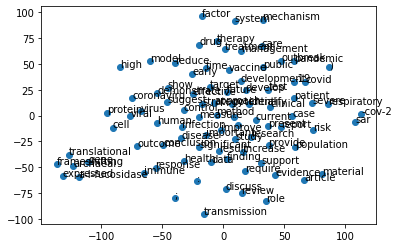

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n = 90

vocab = list(model.wv.key_to_index)
X = model.wv[vocab[:n]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
vocab_df = pd.DataFrame(X_tsne, index=vocab[:n], columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vocab_df['x'], vocab_df['y'])
for word, pos in vocab_df.iterrows():
    ax.annotate(word, pos)

### GLOBALE QE
Standardvariante wie z.B. auf Basis von Wikipedia.

# 1. Standard-Query an den Index für erstes Ranking
Aus dem Title des Topics, quasi wie in der Standard-Pipeline in Pyterrier.
Paper Inverse Document Frequency model (InL2)
Zuerst BM25.

In [75]:
# Create index only to retrieve the tokens from it
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
trec_covid_index_ref = build_index('trecCovid',dataset)
trec_covid_index = pt.IndexFactory.of(trec_covid_index_ref)
#display(dataset.get_topics().columns)
#display(dataset.get_topics())
#display(dataset.get_qrels())

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]C:\Users\timm_\AppData\Local\Temp\ipykernel_22092\2435075576.py:60: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use kwargs in constructor instead
  index_created = indexer.index(dataset.get_corpus_iter(),
cord19/trec-covid documents: 100%|██████████| 192509/192509 [01:35<00:00, 2006.31it/s]


In [96]:

title_queries = dataset.get_topics('title')
bm25 = pt.BatchRetrieve(trec_covid_index , wmodel='BM25', num_results=10)
#res = bm25.transform(title_queries)
experiment = run_experiment(trec_covid_index, title_queries, dataset.get_qrels())
print(experiment)



BR(DPH): 100%|██████████| 50/50 [00:02<00:00, 22.61q/s]


          name    P@5   P@10   nDCG@10      nDCG  RR(rel=2)       map
0       TF_IDF  0.704  0.690  0.611849  0.403892   0.666306  0.207538
1         BM25  0.704  0.690  0.611849  0.403892   0.666306  0.207538
2         InL2  0.704  0.690  0.611849  0.403892   0.666306  0.207538
3  bo1 >> bm25  0.688  0.662  0.593711  0.427600   0.637201  0.224781


# 2. Erstellung der Termkandidaten
## 2.1 Top-3 Dokumente
Alle Terme (ausschließlich der Stoppworte).

## 2.2 Terme der Referenzen
Alle Terme aus den Referenzen der 3 Dokumente (Terme der Titel).

## 2.3 Erweiterung mit Co-Autoren
Über die Koautoren können noch weitere Dokumente bzw. die entsprechenden Terme hinzugefügt werden. Aus Zeitgründen könnte man vielleicht auch diesen Schritt weglassen, wenn es zu viel Aufwand ist über Koautoren weitere Dokumente zu finden. Bei der Implementierung scheint ihr ja aber schon recht weit zu sein. Die "relevanten Paper der Autoren" sind einfach die Top-k Dokumente oder möglicherweise alle zusätzlichen Papers, die über die Koautorenschaft gefunden werden, gemeint. Daher ergibt sich auf der Name PSEUDO-Relevanz-Feedback, da einfach angenommen wird, dass die Top-Treffer alle relevant sind.

# 2.4 Ranking aller Terms
Paper: Bo1
Top-k Terme auswählen (k selbst wählen).
Ergebnis: Potentielle Kandidaten für eine Termwerweiterung

# 2.5 Word2Vec-Modell mit Terms nachtrainieren
Über die Kosinusähnlichkeit der Embeddings der ursprünglichen Anfrageterme bestimmt ihr nun weitere Terme aus dem Word2Vec-Modell. Diese Termkandidaten werden dann wie in 2.1.4 über Bo1 o.ä. gerankt.

In [ ]:
mv_model = Word2Vec.load("data/word2vec.model")

# 2.6 Zwei Sets zusammenfügen und Top-k für QE der ursprünglichen Querry nutzen
Diese jeweils für die 50 Topics absenden.

Ergebnis: Die finalen Rankings, die dann ausgewertet werden können.